In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister, execute
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.ignis.verification import marginal_counts
from qiskit.result import marginal_counts
import matplotlib.pyplot as plt
import time


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  


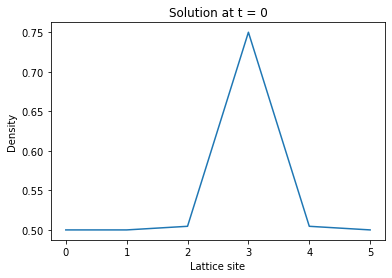

In [2]:
# D1Q2 lattice constants
L = 5  #domain length
M = L+1  # number of lattice sites
x = np.array(range(M))
D = 0.15    #diffusion constant
w = np.array([0.5, 0.5]) # weight coeffecients
cx = np.array([1, -1])   #lattice velocities
csq = 1   #square of sound speed
ux = 0.  # advection x-velocity
# numberOfShots = 100
sigma0 = L/10
mu0 = np.ceil(L/2)

def compute_feq(rho, w, cx, ux, csq):
    feq = np.zeros((2,M))
    for i in range(2):
        feq[i] = w[i] * (1 + cx[i]*ux/csq) * rho
    return feq

def ini(x, w, cx, ux, csq):
    M = len(x)
#     rho = np.ones(M)    #initial density
    rho = 1/4 * np.exp(-(x-mu0)**2 / sigma0**2) + 1/2
    feq = compute_feq(rho, w, cx, ux, csq)
    f = feq
    return f, rho

f, rho = ini(x, w, cx, ux, csq)
plt.plot(x, rho)
plt.xlabel('Lattice site')
plt.ylabel('Density')
plt.title('Solution at t = 0' )
plt.savefig('initial_solution_M' + str(M) )

In [3]:
# qc1 = QuantumCircuit(2*M)

def update_encoding(qc, f, M):
    for k in range(M):
        for i in range(2):    
            amp0 = np.sqrt(1-f[i][k])
            amp1 = np.sqrt(f[i][k])
#             print(amp0,amp1)
#             print('########')
            qc.initialize([amp0, amp1], i+2*k)  
    return qc

# qc = update_encoding(qc1, f, M)
# qc.draw()



In [4]:
def collision_Diffusion(circ, k):
    circ.cx(0+2*k, 1+2*k)
    circ.csx(1+2*k, 0+2*k)
    circ.cx(0+2*k, 1+2*k)
    circ.draw()
    return circ

def collision_Burgers(circ, k):
    circ.cx(0+2*k, 1+2*k)
    circ.ch(1+2*k, 0+2*k)
    circ.cx(1+2*k, 0+2*k)
    circ.cx(0+2*k, 1+2*k)
    circ.cz(0+2*k, 1+2*k)
    circ.draw()
    return circ

# qc.barrier()
# for k in range(M):
#     qc = collision_Diffusion(qc, k)
# qc.draw()

In [47]:
# # Retrieve the statevector_simulator backend
backend = Aer.get_backend('statevector_simulator')

result = execute(qc, backend, shots=10000).result()

# Get the statevector from result().
statevector = result.get_statevector(qc)
array_to_latex(statevector, prefix="\\text{Statevector = }")

<IPython.core.display.Latex object>

In [8]:
# print(qubit_counts[5]['1'])  # proba of qubit q5 at state 1
def classical_streaming(M, qubit_counts, numberOfShots):
    #read post collision probabilities
    fout = np.zeros((2,M))
    for k in range(M):
        for i in range(2):
            fout[i][k] = qubit_counts[i+2*k]['1'] / numberOfShots
    
#     print('fout', fout)
    # classical streaming
    for k in range(1,M):    #right 
        f[0][k] = fout[0][k-1]

    for k in range(M-1):     #left
        f[1][k] = fout[1][k+1]

    #periodic BC
    f[0][0] = f[0][M-1]
    f[1][M-1] = f[1][0]

    return f

# f = classical_streaming(M, qubit_counts, numberOfShots)
# rho = f[0] + f[1]
# t=0
# rho_exact = 1/4 * sigma0 / np.sqrt(sigma0**2 + 4*D*(t+1)) * np.exp(-(x-mu0)**2 / (sigma0**2 + 4*D*(t+1))) + 1/2
# print('f', f)
# print('rho', rho)
# plt.plot(x, rho)
# plt.plot(x, rho_exact)

In [6]:
def oneTimeStep(f, M, numberOfShots):
    qc = QuantumCircuit(2*M)
    #step1: encoding
    qc = update_encoding(qc, f, M)
    qc.barrier()
    #step2: collision
    for k in range(M):
        qc = collision_Diffusion(qc, k)
    #step3: measurement
    qc.measure_all()
#     qc.draw()
    svsim = Aer.get_backend('aer_simulator')
    result = execute(qc, svsim, shots=numberOfShots).result()
    counts = result.get_counts(qc)
    qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(2*M)]
#     print(qubit_counts)
    #step4: streaming
    f = classical_streaming(M, qubit_counts, numberOfShots)
    return f, qc

In [5]:
# Classical implementation of Yepez algorithm
# number operators
n1 = np.array([[0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]])
n2 = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
 
# collision operator  
C_Burgers = np.array([[1, 0, 0, 0],
                      [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
                      [0, -1/np.sqrt(2), 1/np.sqrt(2), 0],
                      [0, 0, 0, -1]])

C_Diffusion = np.array([[1, 0, 0, 0],
                      [0, (1+complex(0,1))/2 , (1-complex(0,1))/2 , 0],
                      [0, (1-complex(0,1))/2 , (1+complex(0,1))/2 , 0],
                      [0, 0, 0, 1]])


def classicalOneTimeStep(f, M):
#     initial combined state
    initial_state = np.zeros((M, 4))
    for i in range(M):
        amp00 = np.sqrt( (1-f[0][i]) * (1-f[1][i]) )#2nd index = lattice site
        amp10 = np.sqrt( (1-f[0][i]) * f[1][i] )
        amp01 = np.sqrt( (1-f[1][i]) * f[0][i] )
        amp11 = np.sqrt( f[0][i] * f[1][i] )
#         print(amp00)
        initial_state[i][0] = amp00
        initial_state[i][1] = amp01
        initial_state[i][2] = amp10
        initial_state[i][3] = amp11
    

#     post-collision state (4xlattice_sites)
    post_collision_state = C_Diffusion.dot(initial_state.conjugate().transpose())
   # post-collision distribution
#     print(post_collision_state.transpose())

    post_collision_distribution = np.zeros((2, M))
    for i in range(M):
        post_collision_distribution[0][i] = post_collision_state.conjugate().transpose()[i].dot(n1.dot( post_collision_state.transpose()[i]))
        post_collision_distribution[1][i] = post_collision_state.conjugate().transpose()[i].dot(n2.dot( post_collision_state.transpose()[i]))
#         if i == 2:
#             print(i)
#             print(post_collision_state.conjugate().transpose()[i])
#             print(post_collision_state.transpose()[i])
    
#     print(post_collision_distribution)


#     STREAMING STEP 
    f[0][1:M] = post_collision_distribution[0][0:M-1]
    f[1][0:M-1] = post_collision_distribution[1][1:M]

#      periodic BC
    f[0][0] = f[0][M-1]
    f[1][M-1] = f[1][0]

    return f

Main code

t =  1


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


Time elapsed in (s)=  32.87608003616333
rho =  [0.4922 0.4949 0.6336 0.5001 0.6326 0.4922]
rhoClassical =  [0.50228947 0.50228945 0.62500001 0.50457891 0.62500001 0.50228947]


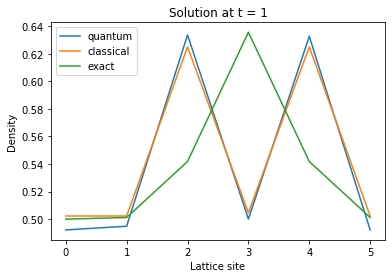

In [9]:
numberOfShots = 10000
fini, rho = ini(x, w, cx, ux, csq)    #only once initially
# print(f)
maxT = 1   #number of time steps
#initialize
fq = fini
fClassical = fini
startTime = time.time()
#main loop
for t in range(1,maxT+1):
    print('t = ', t)
    #quantum implementation
    fq, qc = oneTimeStep(fq, M, numberOfShots)
    rho = fq[0] + fq[1]
    #classical implementation
    fClassical = classicalOneTimeStep(fClassical, M)
    rhoClassical = fClassical[0] + fClassical[1]
    #analytical solution
    rho_exact = 1/4 * sigma0 / np.sqrt(sigma0**2 + 4*D*t) * np.exp(-(x-mu0)**2 / (sigma0**2 + 4*D*t)) + 1/2

elapsed = time.time() - startTime
print('Time elapsed in (s)= ', elapsed)
print('rho = ', rho)
print('rhoClassical = ', rhoClassical)

plt.plot(x, rho)
plt.plot(x, rhoClassical)
plt.plot(x, rho_exact)
plt.legend(['quantum', 'classical', 'exact'])
plt.xlabel('Lattice site')
plt.ylabel('Density')
plt.title('Solution at t = ' + str(maxT))
plt.savefig('t' + str(maxT) + '_M' + str(M) + '_D' + str(D) + '_' + str(numberOfShots) + 'shots.png')